<a href="https://colab.research.google.com/github/LueMar-R/P32_medical_image_segmentation/blob/main/medical_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Image Segmentation

In [1]:
import os
from PIL import Image
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import time

import skimage
from skimage import io, util, filters, transform

from keras import models, layers, optimizers, backend
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/P32_medical_image_segmentation'

/content/drive/MyDrive/P32_medical_image_segmentation


In [ ]:
!unzip -q data_seg.zip

In [4]:
data_path = "../P32_medical_image_segmentation/data_seg/"

directories_list = os.listdir(data_path)
print(directories_list)

['test', 'train', 'label']


## Preprocessing

### Converting images to PNG

In [ ]:
def tif_to_png(directory):
    os.chdir(f"data_seg/{directory}")

    for f in os.listdir():
        if f.endswith("tif"):
            with Image.open(f) as im : # opening images and resaving it to png with PIL
                name, ext = f.split('.')
                name = int(name)
                if name<10 :
                    dest = "00"+str(name)+".png"
                elif (name>=10 and name<100) :
                    dest = "0"+str(name)+".png"
                else :
                    dest = str(name)+".png"
                im.save(dest)

    os.chdir("../..")


def delete_tif(directory):
    os.chdir(f"data_seg/{directory}")

    for f in os.listdir():
        if not f.endswith("png"):
            os.remove(f)

    os.chdir("../..")


In [ ]:
for directory in directories_list:
    tif_to_png(directory)
    delete_tif(directory)

In [ ]:
print("Labelling verification :")
for directory in directories_list :
    print(directory, "\n", os.listdir(f"data_seg/{directory}"))

if os.listdir(f"data_seg/{directories_list[0]}") == os.listdir(f"data_seg/{directories_list[2]}") :
    print("Images ready")
else :
    print("Please check folders content")

Labelling verification :
label 
 ['000.png', '001.png', '010.png', '011.png', '012.png', '013.png', '014.png', '015.png', '016.png', '017.png', '018.png', '019.png', '002.png', '020.png', '021.png', '022.png', '023.png', '024.png', '025.png', '026.png', '027.png', '028.png', '029.png', '003.png', '004.png', '005.png', '006.png', '007.png', '008.png', '009.png']
test 
 ['000.png', '001.png', '010.png', '011.png', '012.png', '013.png', '014.png', '015.png', '016.png', '017.png', '018.png', '019.png', '002.png', '020.png', '021.png', '022.png', '023.png', '024.png', '025.png', '026.png', '027.png', '028.png', '029.png', '003.png', '004.png', '005.png', '006.png', '007.png', '008.png', '009.png']
train 
 ['000.png', '001.png', '010.png', '011.png', '012.png', '013.png', '014.png', '015.png', '016.png', '017.png', '018.png', '019.png', '002.png', '020.png', '021.png', '022.png', '023.png', '024.png', '025.png', '026.png', '027.png', '028.png', '029.png', '003.png', '004.png', '005.png', '00

### Building train set

In [5]:
# importing data with skimage to obtain matrices

base_X_train = np.asarray([io.imread("data_seg/train/"+img) for img in os.listdir("data_seg/train")], np.uint8)
base_Y_train = np.asarray([io.imread("data_seg/label/"+img) for img in os.listdir("data_seg/label")], np.uint8)
base_X_test = np.asarray([io.imread("data_seg/test/"+img) for img in os.listdir("data_seg/test")], np.uint8)

In [6]:
# checking the number of values in segmentation

print("There are", len(np.unique(base_Y_train)), 'different segmentation values')

There are 2 different segmentation values


### Visualization

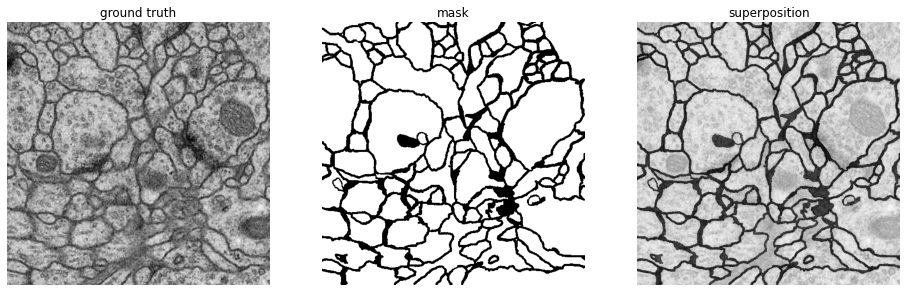

In [7]:
#example with the first image
plt.figure(figsize=(16,5))

plt.subplot(131)
plt.imshow(base_X_train[0], "gray", vmin=0, vmax=255)
plt.axis("off")
plt.title("ground truth")

plt.subplot(132)
plt.imshow(base_Y_train[0], "gray", vmin=0, vmax=255)
plt.axis("off")
plt.title("mask")

I = base_X_train[0]/2 + base_Y_train[0]/2 # supperposition des deux images
plt.subplot(133)
plt.imshow(I, "gray", vmin=0, vmax=255)
plt.axis("off")
plt.title("superposition")

plt.show()

In [8]:
## brouillon 
# On the left > groung truth
# center > mask : the way the model is supposed tu segment the image. Wha can see that some of the dark points are supposed to be segmented as contours, while some others are considered as cells.

### Data augmentation

In [9]:
# a data augmentation method, using skimage
def random_transformation(real, mask):
    random_degree = random.uniform(-25, 25)
    real, mask = [skimage.transform.rotate(img, random_degree) for img in [real, mask]]
    real = skimage.util.random_noise(real)
    random_flipping = random.choice(["vert", "hori", "none"])
    real, mask = [(img[::-1,:] if random_flipping=="vert" else img[:,::-1] if random_flipping=="vert" else img) for img in [real, mask]]
    return real, mask

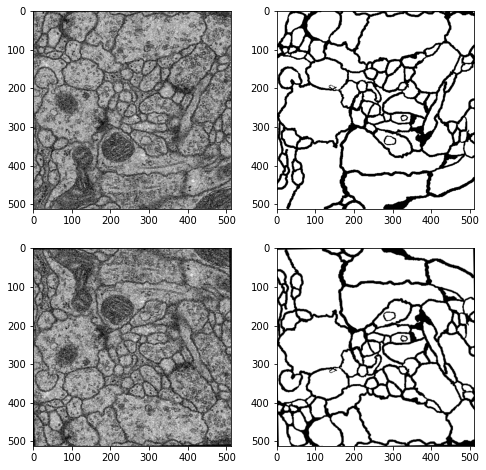

In [10]:
# results visualisation 
random_indice = random.randrange(len(base_X_train))
new_img, new_mask = random_transformation(base_X_train[random_indice], base_Y_train[random_indice])

plt.figure(figsize = (8,8))
plt.subplot(221)
plt.imshow(base_X_train[random_indice], "gray", vmin=0, vmax=255)
plt.subplot(222)
plt.imshow(base_Y_train[random_indice], "gray", vmin=0, vmax=255)
plt.subplot(223)
plt.imshow(new_img, "gray")
plt.subplot(224)
plt.imshow(new_mask, "gray")
plt.show()

In [12]:
X = base_X_train
Y = base_Y_train

i=0
a = time.time()
while i<770:
    random_indice = random.randrange(len(base_X_train))
    new_img, new_mask = random_transformation(base_X_train[random_indice], base_Y_train[random_indice])
    X = np.vstack((X, new_img.reshape(1, 512, 512)))
    Y = np.vstack((Y, new_mask.reshape(1, 512, 512).round(0)))
    i+=1
print("time to process data augmentation :", (time.time()-a)//60, "min.", np.round((time.time()-a)%60, 0))

time to process data augmentation : 6.0 min. 0.0


In [13]:
print(len(X), len(Y))

800 800


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=42)

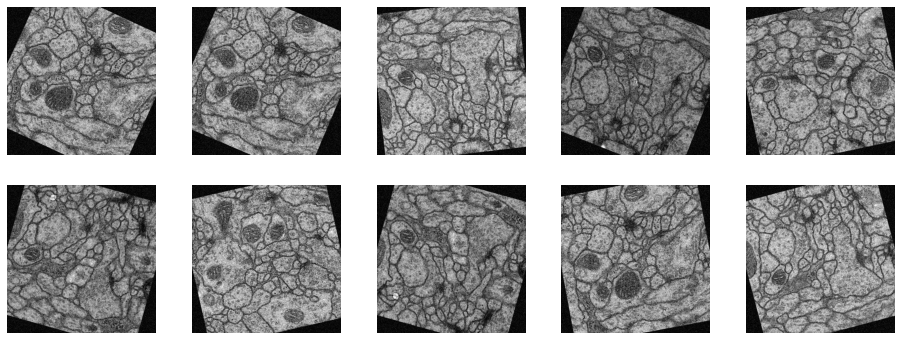

In [15]:
plt.figure(figsize=(16, 6))
for i in range(10):
  ax = plt.subplot(2, 5, i + 1)
  plt.imshow(X_train[i], "gray")
  plt.axis("off")

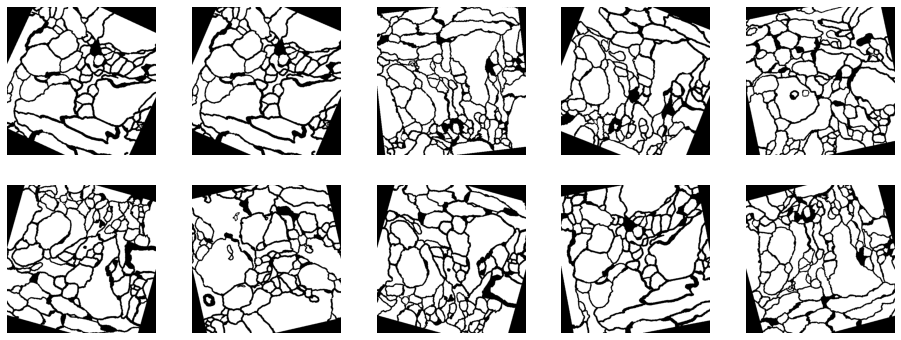

In [16]:
plt.figure(figsize=(16, 6))
for i in range(10):
  ax = plt.subplot(2, 5, i + 1)
  plt.imshow(Y_train[i], "gray")
  plt.axis("off")

In [17]:
# check that we still have 2 values for segmentation
print(np.unique(Y_train[0]))
# check that values are normalized
print(np.min(X_train[0:10]), np.max(X_train[0:10]))

[0. 1.]
0.0 1.0


In [18]:
np.save('X_train.npy', X_train)
np.save('Y_train.npy', Y_train)
np.save('X_val.npy', X_val)
np.save('Y_val.npy', Y_val)

In [19]:
X_train = np.load('X_train.npy')
Y_train = np.load('Y_train.npy')
X_val  = np.load('X_val.npy')
Y_val = np.load('Y_val.npy')

## Model Training

In [20]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# Dice loss definition based on https://gist.github.com/wassname/7793e2058c5c9dacb5212c0ac0b18a8a

In [21]:
# the following function creates a U-Net model when called.

def make_unet(ROWS, COLS):
    inputs = Input((ROWS, COLS, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = models.Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=optimizers.Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])

    return model


In [22]:
modelX = make_unet(512, 512)

history = modelX.fit(X_train, Y_train, epochs=50,  batch_size=20, validation_split = 0.2)

Epoch 1/50
24/24 [==============================] - 90s 2s/step - loss: 0.2175 - dice_coef: 0.7825 - val_loss: 0.1532 - val_dice_coef: 0.8468
Epoch 2/50
24/24 [==============================] - 36s 1s/step - loss: 0.1241 - dice_coef: 0.8759 - val_loss: 0.1284 - val_dice_coef: 0.8716
Epoch 3/50
24/24 [==============================] - 36s 2s/step - loss: 0.1229 - dice_coef: 0.8771 - val_loss: 0.1264 - val_dice_coef: 0.8736
Epoch 4/50
24/24 [==============================] - 37s 2s/step - loss: 0.1121 - dice_coef: 0.8879 - val_loss: 0.1245 - val_dice_coef: 0.8755
Epoch 5/50
24/24 [==============================] - 37s 2s/step - loss: 0.1237 - dice_coef: 0.8763 - val_loss: 0.1205 - val_dice_coef: 0.8795
Epoch 6/50
24/24 [==============================] - 38s 2s/step - loss: 0.1167 - dice_coef: 0.8833 - val_loss: 0.1144 - val_dice_coef: 0.8856
Epoch 7/50
24/24 [==============================] - 38s 2s/step - loss: 0.1033 - dice_coef: 0.8967 - val_loss: 0.1134 - val_dice_coef: 0.8866
Epoch 

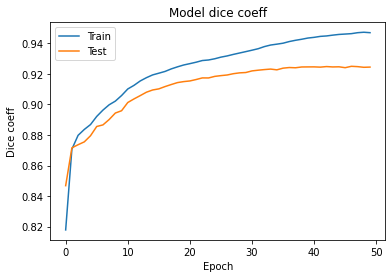

In [23]:
from keras.callbacks import History

plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
Y_pred = modelX.predict(X_val)

In [25]:
Y_pred = np.round(Y_pred,0)
Y_pred = Y_pred.reshape(Y_pred.shape[0:3])

In [26]:
print(Y_pred.shape)

(200, 512, 512)


In [27]:
def show_result_on_an_image(image_number):
    plt.figure(figsize=(16,5))

    plt.subplot(131)
    plt.imshow(Y_pred[image_number], cmap="gray")
    plt.axis("off")
    plt.title("predicted")

    plt.subplot(132)
    plt.imshow(Y_val[image_number], cmap="gray")
    plt.axis("off")
    plt.title("awaited")

    I = Y_pred[image_number]/2 + Y_val[image_number]/2 
    error = np.where(I == 0.5)

    plt.subplot(133)
    plt.imshow(I, cmap="gist_heat")
    plt.axis("off")
    plt.title("error")

    plt.show()

    print(f"{len(error[0])} pixels uncorrectly identified on test image n°{image_number},")
    print("representig", np.round(len(error[0])*100/(Y_val.shape[1]*Y_val.shape[2]),2), "% of pixels on the image.")

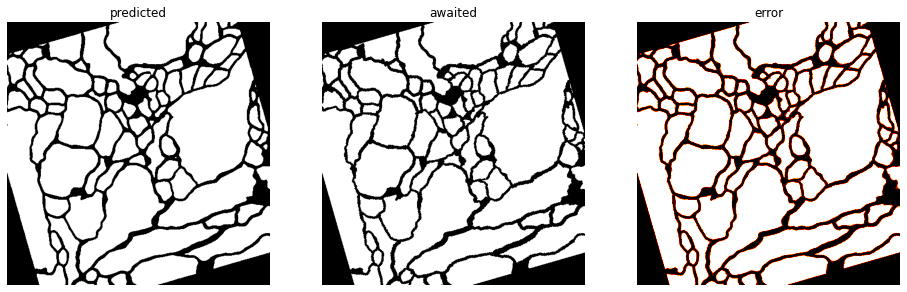

7030 pixels uncorrectly identified on test image n°42,
representig 2.68 % of pixels on the image.


In [28]:
show_result_on_an_image(42)

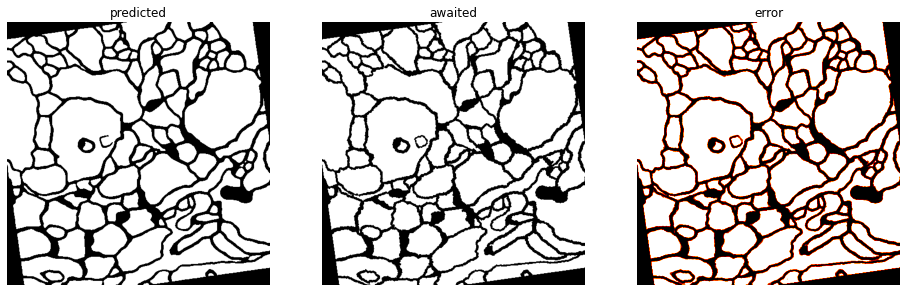

8788 pixels uncorrectly identified on test image n°150,
representig 3.35 % of pixels on the image.


In [29]:
show_result_on_an_image(150)

In [30]:
# The figure above represents ......
# white color = neurites
# red color in the third image highlights the pixels that are uncorrectly identified, .;...

In [31]:
global_error = np.where(Y_pred/2 + Y_val/2  == 0.5)
print("*"*60)
print("¤"*60)
print(" "*10, "Global error on full dataset :", np.round(len(global_error[0])*100/(Y_val.shape[1]*Y_val.shape[2]*Y_val.shape[0]),2), "%.")
print("¤"*60)
print("*"*60)

************************************************************
¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
           Global error on full dataset : 5.25 %.
¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
************************************************************


In [32]:
"""
A faire :
- Augmenter la data à 3000 images (ou plus, la limite, c'est quand ça crash à l'entrainement), en réduisant la taille des images à 256*256 pour pas que ça crashe.
- Améliorer l'algo de Data-Augmentation pour rajouter traitements :
   - voir s'il y a des paramètres pour le skimage.util.random_noise, pour augmenter un peu les effets éventuellement
   - voir s'il peu être interessant de faire des crop.
   - ou éventuellement essayer avec keras plutôt qu'avec Scikit-image
- Voir s'il y des méthodes moins artisanales pour scorer le modèle... (Là c'est du full home-made)
- Commenter le notebook et interpreter les résultats,
- Sortir les prédictions sur le X_test ? (mais quel est l'intérêt vu qu'on a pas les labels ?)
- ...
"""

"\nA faire :\n- Augmenter la data à 3000 images (ou plus, la limite, c'est quand ça crash à l'entrainement), en réduisant la taille des images à 256*256 pour pas que ça crashe.\n- Améliorer l'algo de Data-Augmentation pour rajouter traitements :\n   - voir s'il y a des paramètres pour le skimage.util.random_noise, pour augmenter un peu les effets éventuellement\n   - voir s'il peu être interessant de faire des crop.\n   - ou éventuellement essayer avec keras plutôt qu'avec Scikit-image\n- Voir s'il y des méthodes moins artisanales pour scorer le modèle... (Là c'est du full home-made)\n- Commenter le notebook et interpreter les résultats,\n- Sortir les prédictions sur le X_test ? (mais quel est l'intérêt vu qu'on a pas les labels ?)\n- ...\n"

In [33]:
#pred_dir = 'predictions'
#if not os.path.exists(pred_dir):
#    os.mkdir(pred_dir)

#for i in range(len(Y_val)):
#    a = skimage.exposure.rescale_intensity(X_val[i][:,:,0],out_range=(-1,1))
#    b = (Y_val[i][:,:,0]).astype('uint8')
#    io.imsave(os.path.join(pred_dir, str(i) + '_pred.png'),mark_boundaries(a,b)) #Saving predictions
